In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-24 11:47:18.813309
numcores: 40


In [2]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [3]:
# Working model, inferring mus 
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    #mus=[pm.Uniform('mu{}'.format(i),-5,15,shape=ndim) for i in range(infinity)]
    #plt.hist([pm.Normal.dist(0,10).random() for _ in range(1000)])
    mus=[pm.Normal('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [4]:
nsamples=5000
ntune=1000
ncores=8


trace = pm.sample(draws=nsamples,tune=ntune,cores=ncores,init='auto',n_init=20,model=model)
print(pm.summary(trace));



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu4, mu3, mu2, mu1, mu0, beta, alpha]
Sampling 8 chains, 6,760 divergences:  94%|█████████▍| 45178/48000 [59:15<09:44,  4.83draws/s]

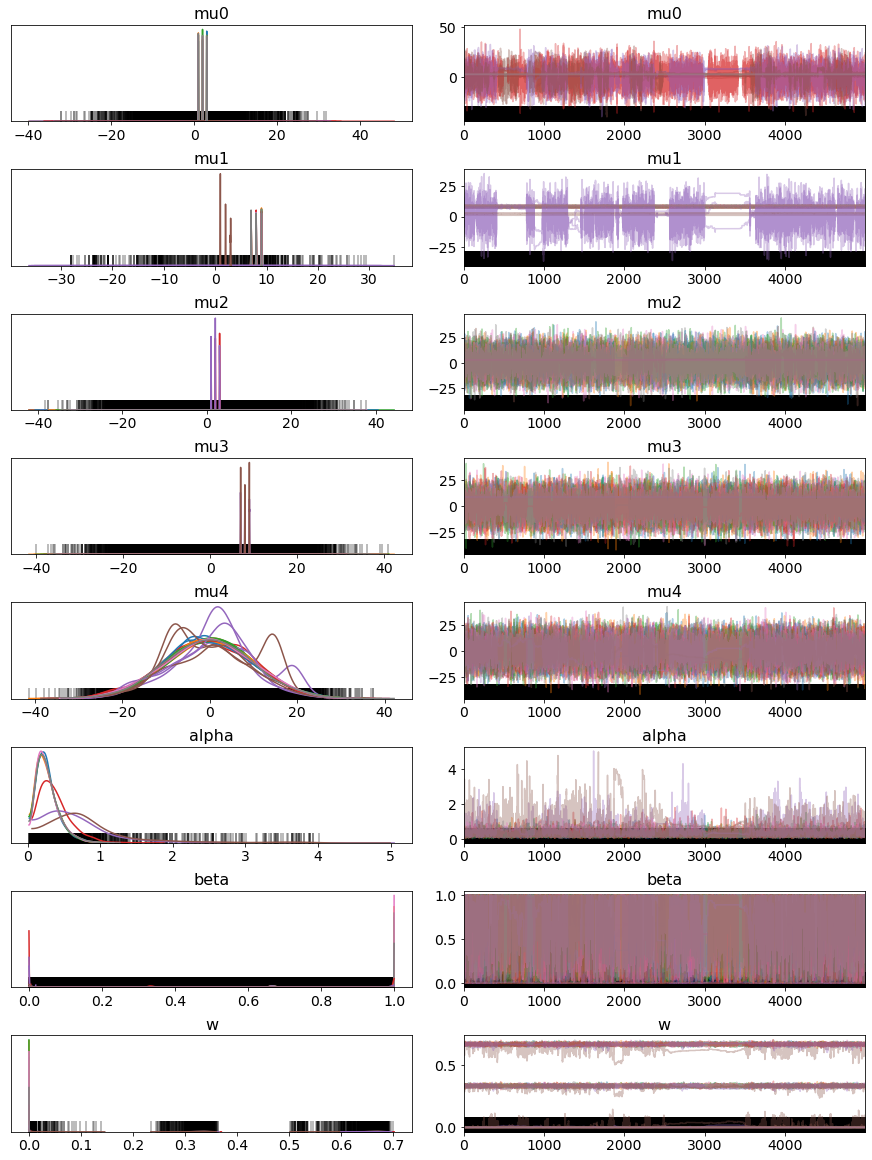

In [5]:
pm.traceplot(trace);

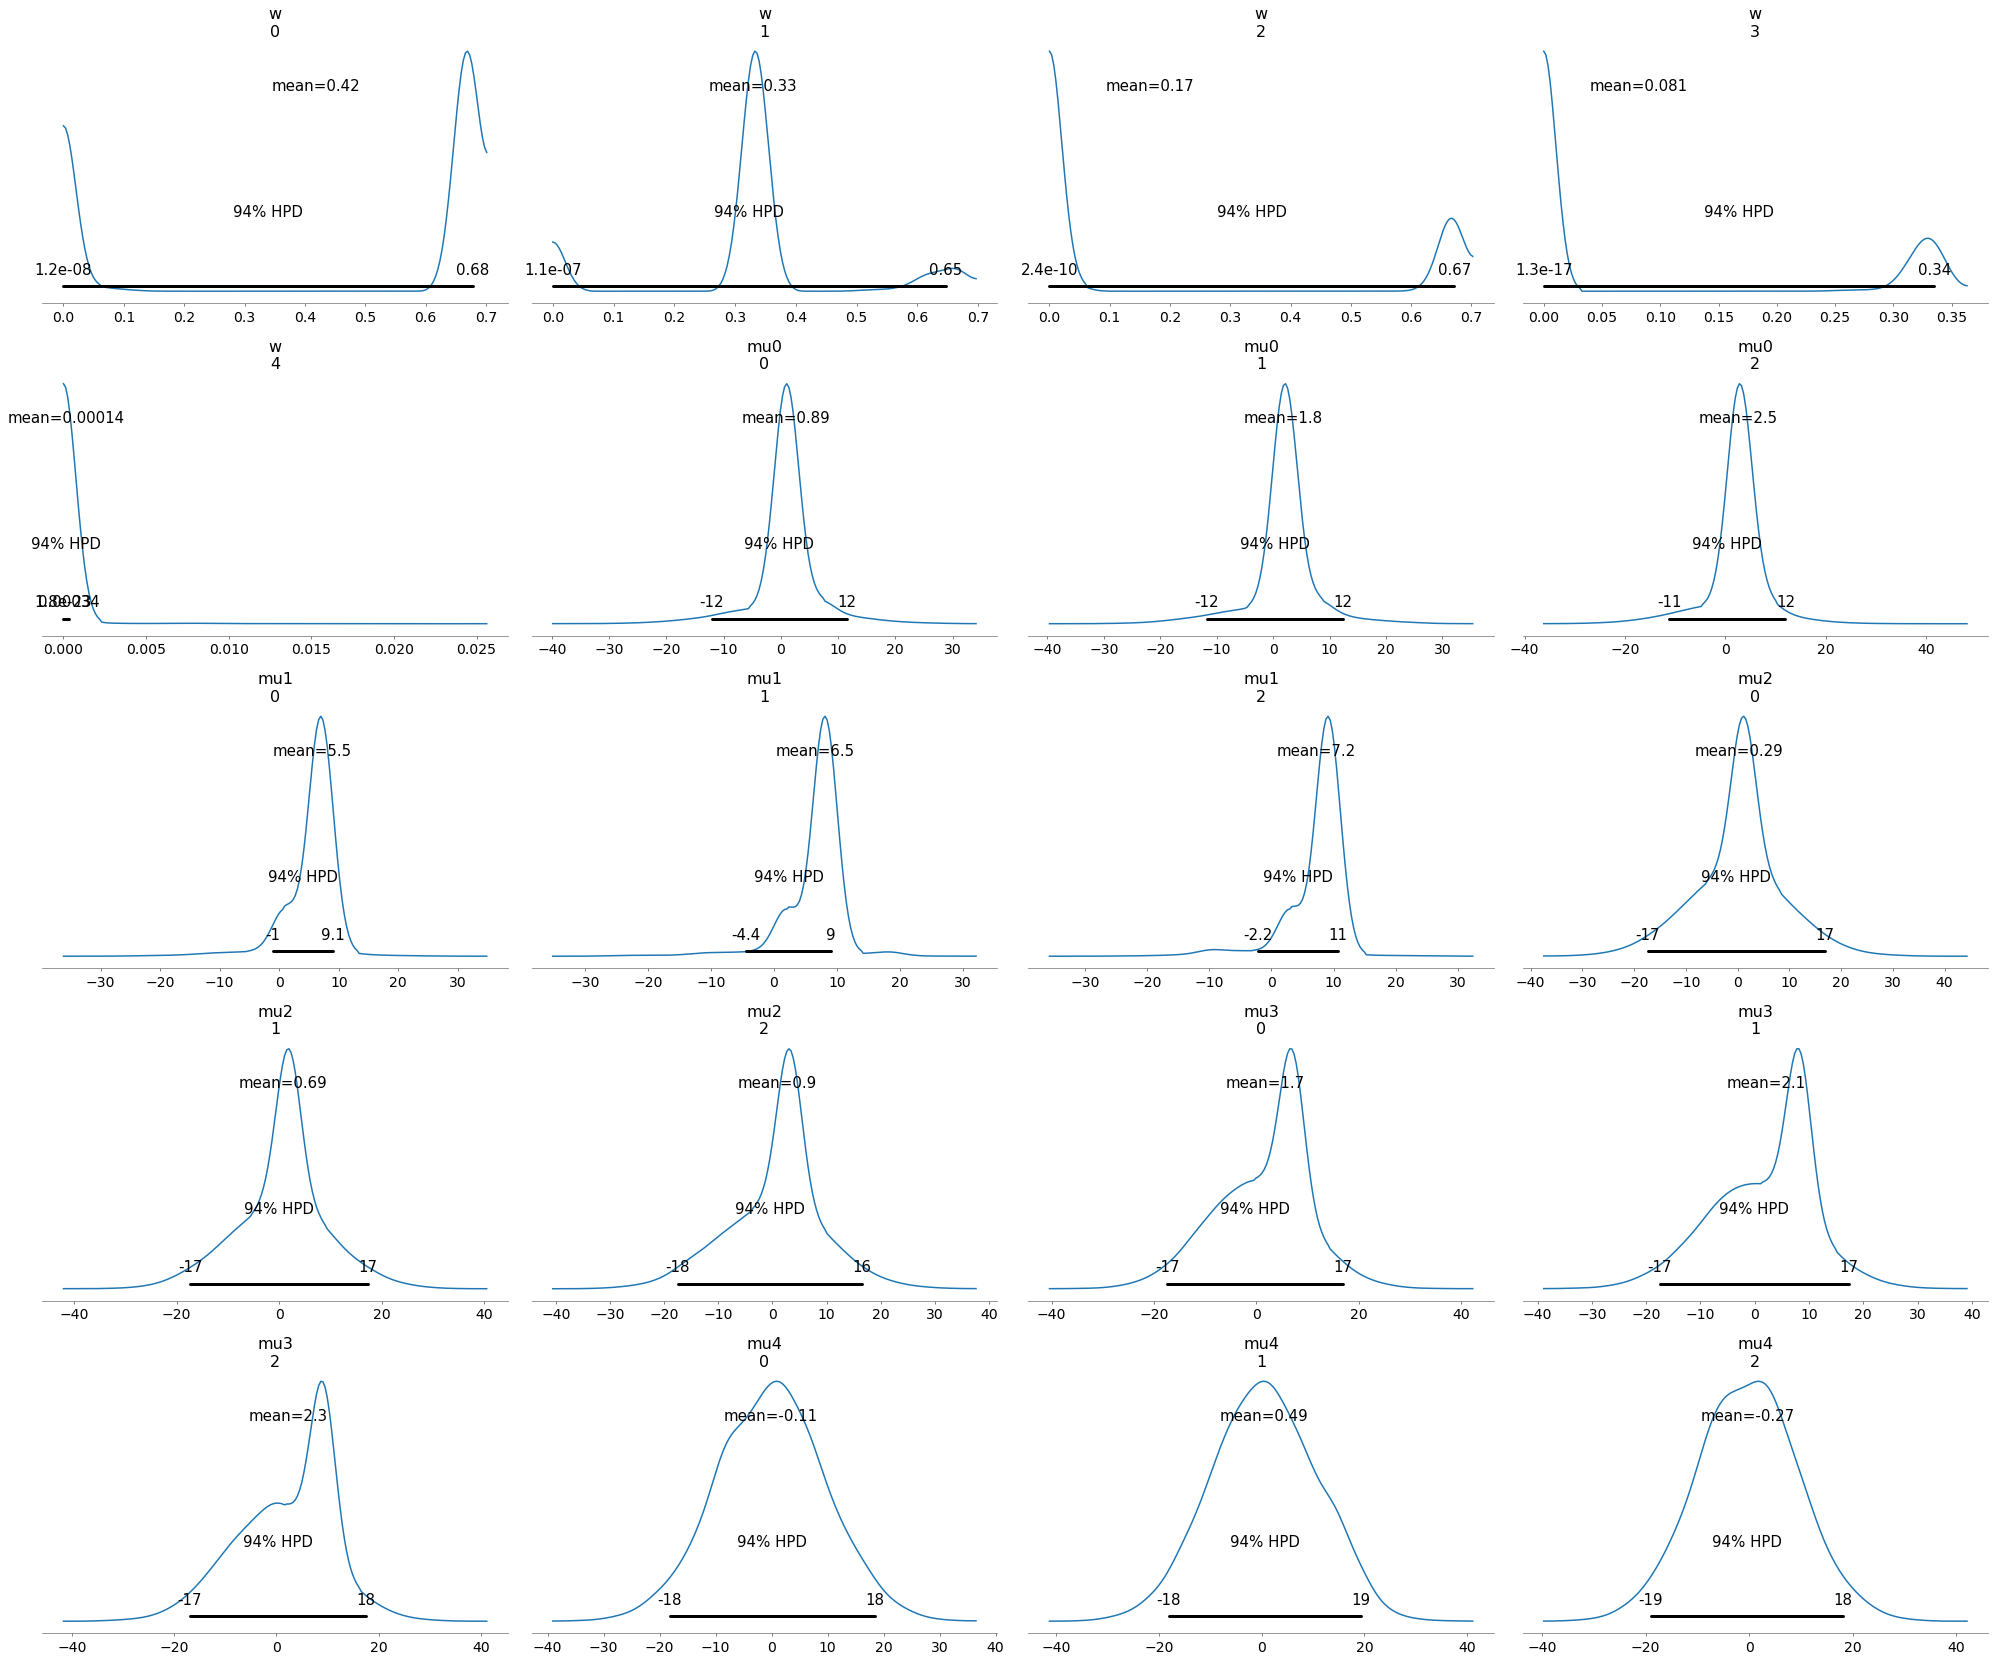

In [6]:
pm.plot_posterior(data=trace,var_names=['w','mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [7]:
t_finish=now()

In [8]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 1:08:47.725485


In [9]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [10]:
#with model:
#    trace = pm.find_MAP()